# Introdução A computação Visual - Trabalho Prático 3
## Luiz Henrique De Melo Santos
## Otávio Augusto Silva

In [1]:
import os
import cv2
import numpy
import tensorflow
from matplotlib import pyplot
from tensorflow.keras import activations, initializers, layers, losses, metrics, models, optimizers, utils

In [2]:
devices = tensorflow.config.list_physical_devices()
try:
    tensorflow.config.experimental.set_memory_growth(devices[1], True)
except:
    print(f"Error when enabling memory growth for device {devices[1]}")

In [3]:
VOCAB = "0123456789ABCDEFGHIJKLMNOPQRSTUVXWYZ"

In [4]:
labels = {}
for filename in os.listdir(os.path.join("CAPTCHA-10k", "labels10k")):
    with open(os.path.join("CAPTCHA-10k", "labels10k", filename), "r") as file:
        line = file.readlines()[0]
        if "?" not in line and len(line) == 7:
            labels[filename.split('.')[0]] = line.replace('\n', '')

In [5]:
vocab_mapping = {i: idx for idx, i in enumerate(VOCAB)}

In [6]:
classes = {}
for key in labels:
    classes[key] = [vocab_mapping[c] for c in labels[key]]

In [7]:
def train_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "treinamento")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "treinamento", filename)) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            X = numpy.split(image, 6, axis=1)
            yield (X, y)

In [8]:
def test_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "teste")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "teste", filename)) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            X = numpy.split(image, 6, axis=1)
            yield (X, y)

In [9]:
def validation_generator():
    for filename in os.listdir(os.path.join("CAPTCHA-10k", "validacao")):
        if filename.split('.')[0] in classes.keys():
            image = cv2.imread(os.path.join("CAPTCHA-10k", "validacao", filename)) / 255
            y = utils.to_categorical(classes[filename.split('.')[0]], num_classes=len(VOCAB))
            X = numpy.array(numpy.split(image, 6, axis=1))
            yield (X, y)

In [10]:
train_dataset = tensorflow.data.Dataset.from_generator(train_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.float32), output_shapes=(tensorflow.TensorShape(((6, 50, 30, 3))), tensorflow.TensorShape((6, 36)))).unbatch()

In [11]:
for item, label in train_dataset.take(1):
    print(item.shape)
    print(label.shape)

(50, 30, 3)
(36,)


In [12]:
validation_dataset = tensorflow.data.Dataset.from_generator(validation_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.float32), output_shapes=(tensorflow.TensorShape(((6, 50, 30, 3))), tensorflow.TensorShape((6, 36)))).unbatch()

In [21]:
test_dataset = tensorflow.data.Dataset.from_generator(test_generator, (tensorflow.dtypes.float32, tensorflow.dtypes.float32), output_shapes=(tensorflow.TensorShape(((6, 50, 30, 3))), tensorflow.TensorShape((6, 36))))

In [25]:
def create_model(shape: tuple):
    inputs = tensorflow.keras.Input(shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation=activations.relu, bias_initializer=tensorflow.ones)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation=activations.relu, bias_initializer=tensorflow.ones)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation=activations.relu, bias_initializer=tensorflow.ones)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation=activations.relu, bias_initializer=tensorflow.ones)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation=activations.relu, bias_initializer=tensorflow.ones)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation=activations.relu, bias_initializer=tensorflow.ones)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(VOCAB), activation=activations.softmax, bias_initializer=tensorflow.ones)(x)
    return models.Model(inputs=inputs, outputs=outputs)

In [26]:
model = create_model((50, 30, 3))

In [27]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 30, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 30, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 50, 30, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 30, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 50, 30, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 15, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 15, 64)        3692

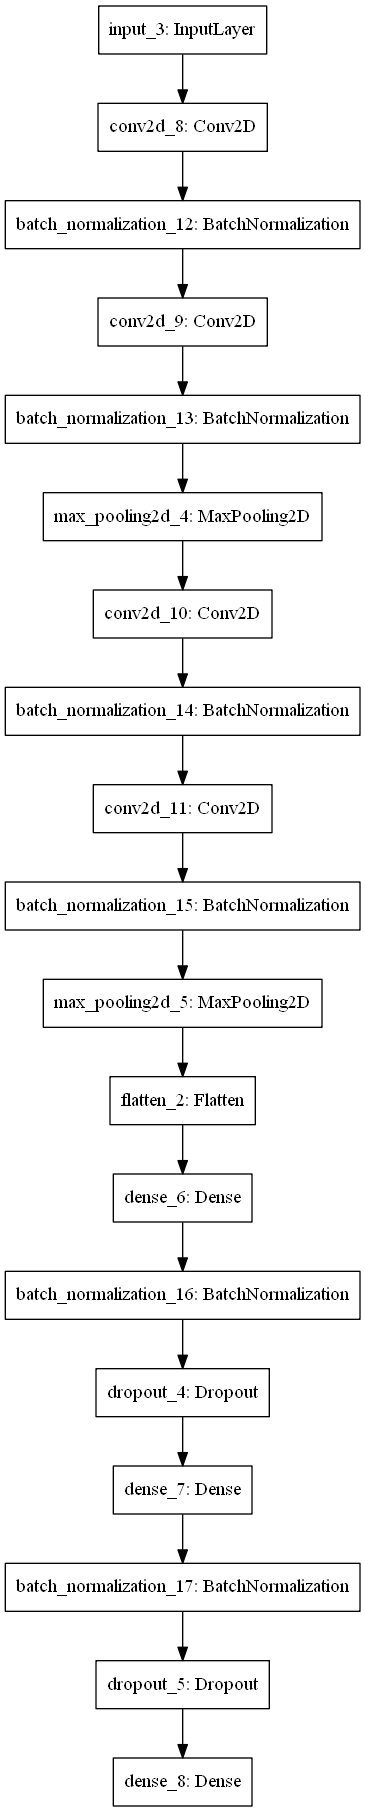

In [28]:
utils.plot_model(model)

In [29]:
model.compile(optimizer=optimizers.Adam(), loss=losses.CategoricalCrossentropy(), metrics=[metrics.CategoricalAccuracy()])

In [30]:
history = model.fit(train_dataset.batch(128), validation_data=validation_dataset.batch(128), epochs=10)

Epoch 1/10
288/288 [==============================] - 17s 59ms/step - loss: 1.0670 - categorical_accuracy: 0.6902 - val_loss: 0.9633 - val_categorical_accuracy: 0.7138
Epoch 2/10
288/288 [==============================] - 15s 52ms/step - loss: 0.3307 - categorical_accuracy: 0.9008 - val_loss: 0.3104 - val_categorical_accuracy: 0.8945
Epoch 3/10
288/288 [==============================] - 15s 52ms/step - loss: 0.2392 - categorical_accuracy: 0.9285 - val_loss: 0.2113 - val_categorical_accuracy: 0.9290
Epoch 4/10
288/288 [==============================] - 15s 52ms/step - loss: 0.1915 - categorical_accuracy: 0.9411 - val_loss: 0.2212 - val_categorical_accuracy: 0.9264
Epoch 5/10
288/288 [==============================] - 15s 52ms/step - loss: 0.1593 - categorical_accuracy: 0.9507 - val_loss: 0.2158 - val_categorical_accuracy: 0.9279
Epoch 6/10
288/288 [==============================] - 15s 52ms/step - loss: 0.1325 - categorical_accuracy: 0.9590 - val_loss: 0.2236 - val_categorical_accuracy:

In [36]:
model.evaluate(test_dataset.batch(128))

ValueError: in converted code:

    C:\tools\miniconda3\envs\default\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    C:\tools\miniconda3\envs\default\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    C:\tools\miniconda3\envs\default\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:573 standardize_input_data
        'with shape ' + str(data_shape))

    ValueError: Error when checking input: expected input_3 to have 4 dimensions, but got array with shape (None, 6, 50, 30, 3)
